In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kmapper as km
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr
import networkx as nx
import hdbscan
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
df_departures = pd.read_pickle("../../calculated_distances_dep.pkl")

df_arrivals = pd.read_pickle("../../calculated_distances_arr.pkl")

print("Columns all:")
print(df_departures.columns.tolist())

Columns all:
['airportCode', 'date', 'deviation', 'delay']


In [3]:
df_arrivals_long_delay = df_arrivals[df_arrivals['delay'] < -500]
print(df_arrivals_long_delay)

       airportCode       date    deviation       delay
565414        LEAB 2018-09-22  1943.935833 -556.766667


In [4]:
# Filter month july

df_departures = df_departures[df_departures['date'].dt.month == 8]

df_arrivals = df_arrivals[df_arrivals['date'].dt.month == 8]

In [5]:
df_dep_by_airport = df_departures.groupby(['airportCode']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()

df_dep_by_airport.columns = ['airportCode',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_arr_by_airport = df_arrivals.groupby(['airportCode']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()


df_arr_by_airport.columns = ['airportCode',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_all_by_airport = pd.merge(df_dep_by_airport, df_arr_by_airport, on=['airportCode'], suffixes=('_dep', '_arr'))



print(df_all_by_airport.head())

print(df_all_by_airport.shape)

  airportCode  deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0        GCFV         2258.323285           1305.709678        2506.521412   
1        GCGM          222.664857            170.764528         221.824574   
2        GCHI          334.160151            311.161048         182.278662   
3        GCLA          793.513205            260.209258        1360.546629   
4        GCLP         1505.083703            571.067927        2115.941267   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2390.310402       -0.574700         -2.616667      13.899186   
1         365.273114       -6.159318         -7.716667       8.536521   
2         208.013264       -2.233561         -3.958333       9.088458   
3         339.883125       -0.924181         -2.175000       8.801620   
4        2034.578941        0.065664         -1.016667      11.431228   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0      14.2

In [6]:
df_dep_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_dep_by_airport.isna().sum())

print()
df_arr_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_arr_by_airport.isna().sum())


print()
df_all_by_airport.fillna({'deviation_std_dep': 0.0, 'delay_std_dep': 0.0, 'deviation_std_arr': 0.0, 'delay_std_arr': 0.0}, inplace=True)
print(df_all_by_airport.isna().sum())

airportCode         0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode         0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode             0
deviation_mean_dep      0
deviation_median_dep    0
deviation_std_dep       0
deviation_iqr_dep       0
delay_mean_dep          0
delay_median_dep        0
delay_std_dep           0
delay_iqr_dep           0
deviation_mean_arr      0
deviation_median_arr    0
deviation_std_arr       0
deviation_iqr_arr       0
delay_mean_arr          0
delay_median_arr        0
delay_std_arr           0
delay_iqr_arr           0
dtype: int64


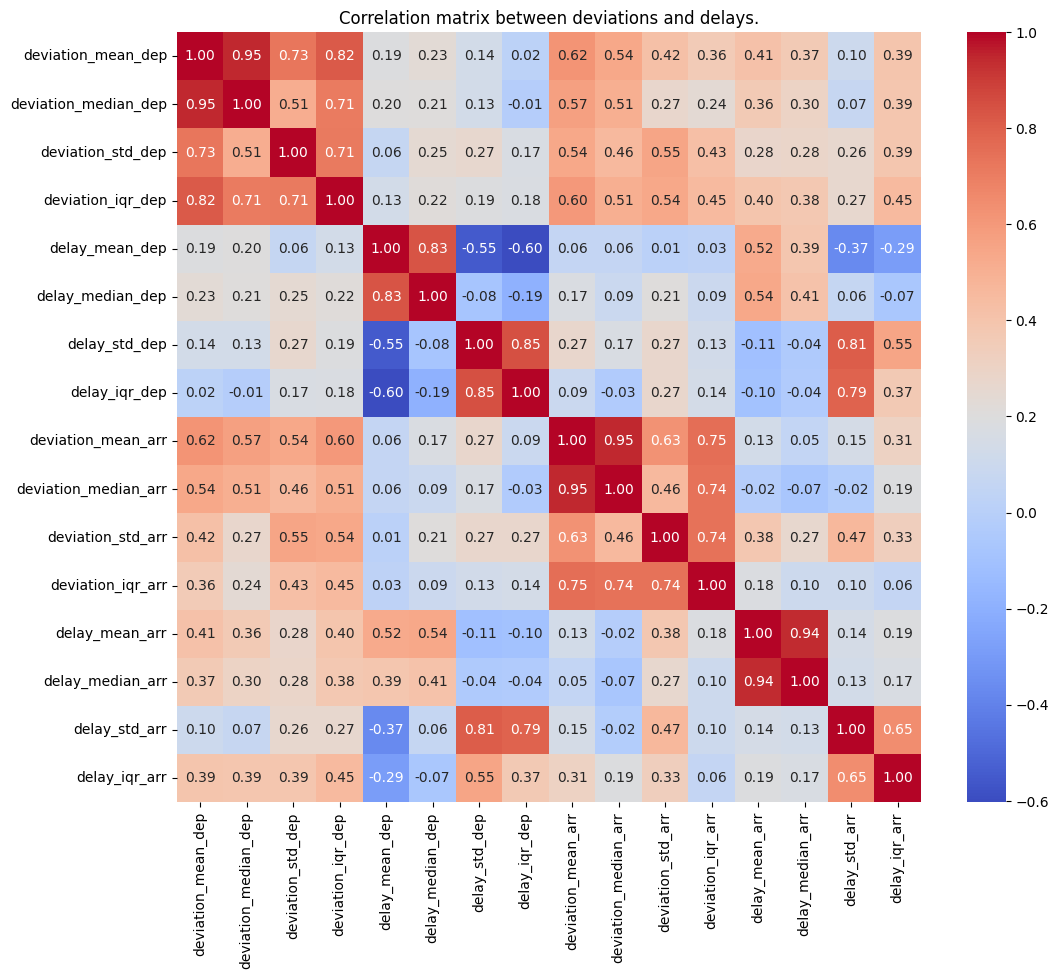

In [7]:
df_numeric = df_all_by_airport.drop(columns=['airportCode'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix between deviations and delays.")
plt.show()

In [8]:
df_spanish_airports = pd.read_pickle('../../spanish_airports.pkl')

X_all = df_all_by_airport.drop(columns=['airportCode']).dropna()

print(X_all.head())
print()

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

custom_tooltips_all = np.array([
     f"{df_spanish_airports.loc[df_spanish_airports['ICAO'] == row['airportCode'], 'Aeropuerto'].values[0] }" for _, row in df_all_by_airport.iterrows()
])

print(X_scaled_all)

   deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0         2258.323285           1305.709678        2506.521412   
1          222.664857            170.764528         221.824574   
2          334.160151            311.161048         182.278662   
3          793.513205            260.209258        1360.546629   
4         1505.083703            571.067927        2115.941267   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2390.310402       -0.574700         -2.616667      13.899186   
1         365.273114       -6.159318         -7.716667       8.536521   
2         208.013264       -2.233561         -3.958333       9.088458   
3         339.883125       -0.924181         -2.175000       8.801620   
4        2034.578941        0.065664         -1.016667      11.431228   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0      14.212500         3040.249194           3776.500426        2559.060456   
1 

In [9]:
def graph_stats(graph):
    G = nx.Graph()
    for node_id in graph['nodes'].keys():
        members = graph['nodes'][node_id]
        nombres_miembros = [custom_tooltips_all[i] for i in members]
        G.add_node(node_id, members=nombres_miembros)
    
    for source, targets in graph['links'].items():
        for target in targets:
            G.add_edge(source, target)

    num_nodos = len(graph['nodes'])
    num_enlaces = len(graph['links'])
    densidad = (2 * num_enlaces) / (num_nodos * (num_nodos - 1)) if num_nodos > 1 else 0
    grados = dict(G.degree()).values()
    grado_medio = sum(grados) / len(grados) if len(grados) > 0 else 0
    grado_max = max(grados) if grados else 0
    grado_min = min(grados) if grados else 0
    num_componentes = nx.number_connected_components(G)
    tamaños = [ len(data['members']) 
            for _, data in G.nodes(data=True) ]
    
    tamaño_medio = sum(tamaños) / len(tamaños)
    diametro = nx.diameter(G) if nx.is_connected(G) else max(nx.diameter(G.subgraph(c)) for c in nx.connected_components(G))
    coef_agrupamiento = nx.average_clustering(G) if len(G) > 1 else 0

    centralidad_grado = nx.degree_centrality(G)
    centralidad_betweenness = nx.betweenness_centrality(G)

    print("Número de nodos:", num_nodos)
    print("Número de enlaces:", num_enlaces)
    print("Densidad del grafo:", densidad)
    print("Grados:", grados)
    print("Grado medio de los nodos:", grado_medio)
    print("Grado máximo:", grado_max)
    print("Grado mínimo:", grado_min)
    print("Número de componentes conectados:", num_componentes)
    print("Tamaño medio de cluster:", tamaño_medio)
    print("Tamaños:", tamaños)
    print("Diámetro del grafo:", diametro)
    print("Coeficiente medio de agrupamiento:", coef_agrupamiento)
    print("Centralidad grado:", centralidad_grado)
    print("Centralidad betweeness:", centralidad_betweenness)
    print()
    print("-" * 30)

    for node_id, data in G.nodes(data=True):
        if(data and data['members']):    
            members = data['members']
            cluster_size = len(members)
            print(f"Clúster: {node_id}")
            print(f" - Número de miembros: {cluster_size}")
            print(f" - Miembros: {[str(member) for member in members]}")
            print("-" * 30)
            
    from collections import defaultdict

    apariciones_miembro = defaultdict(int)

    for _, data in G.nodes(data=True):
        if data and 'members' in data:
            for miembro in data['members']:
                apariciones_miembro[miembro] += 1

    print("\nNúmero de nodos en los que aparece cada miembro:")
    for miembro, conteo in apariciones_miembro.items():
        if conteo > 1:
            print(f" - {miembro}: {conteo} nodos")   
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_weight='bold')
    
    plt.show()

Número de nodos: 17
Número de enlaces: 8
Densidad del grafo: 0.058823529411764705
Grados: dict_values([0, 0, 0, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0])
Grado medio de los nodos: 0.9411764705882353
Grado máximo: 2
Grado mínimo: 0
Número de componentes conectados: 9
Tamaño medio de cluster: 3.588235294117647
Tamaños: [1, 1, 2, 2, 1, 5, 1, 7, 1, 8, 11, 2, 1, 10, 5, 2, 1]
Diámetro del grafo: 6
Coeficiente medio de agrupamiento: 0.0
Centralidad grado: {'cube0_cluster0': 0.0, 'cube1_cluster0': 0.0, 'cube2_cluster0': 0.0, 'cube3_cluster0': 0.0, 'cube4_cluster0': 0.0625, 'cube5_cluster0': 0.125, 'cube5_cluster1': 0.0625, 'cube6_cluster0': 0.125, 'cube6_cluster1': 0.0625, 'cube7_cluster0': 0.125, 'cube8_cluster0': 0.125, 'cube8_cluster1': 0.0625, 'cube9_cluster0': 0.0625, 'cube9_cluster1': 0.125, 'cube10_cluster0': 0.0625, 'cube11_cluster0': 0.0, 'cube11_cluster1': 0.0}
Centralidad betweeness: {'cube0_cluster0': 0.0, 'cube1_cluster0': 0.0, 'cube2_cluster0': 0.0, 'cube3_cluster0': 0.0, 'cube4

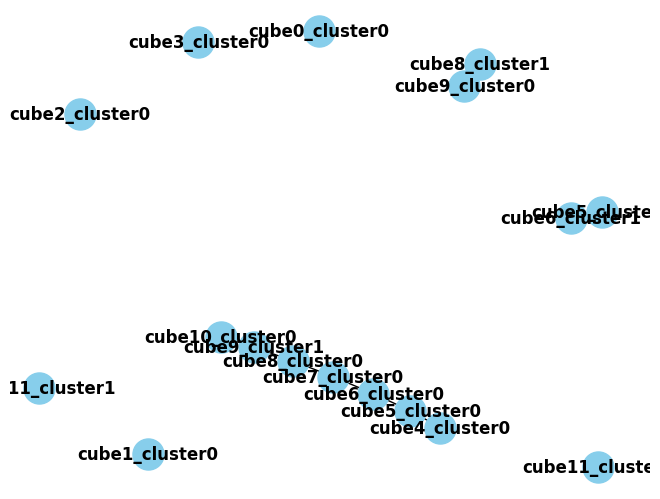

In [10]:
mapper = km.KeplerMapper()

pca = PCA(n_components=3)
filter_values_all = pca.fit_transform(X_scaled_all)

pca = PCA(n_components=1)

projection_all = pca.fit_transform(X_scaled_all)
 
graph_all = mapper.map(projection_all,
                       filter_values_all, 
                    clusterer=DBSCAN(eps=2.5, min_samples=1),
                    cover=km.Cover(n_cubes=12, perc_overlap=0.25)
)

color_values_all = X_scaled_all[:, :16]
color_function_name_all = X_all.columns[:16]

mapper.visualize(graph_all, 
                 path_html="mapper_output_all.html", 
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all)

Número de nodos: 12
Número de enlaces: 4
Densidad del grafo: 0.06060606060606061
Grados: dict_values([0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1])
Grado medio de los nodos: 0.6666666666666666
Grado máximo: 2
Grado mínimo: 0
Número de componentes conectados: 8
Tamaño medio de cluster: 3.6666666666666665
Tamaños: [8, 2, 2, 3, 3, 2, 3, 2, 2, 11, 3, 3]
Diámetro del grafo: 2
Coeficiente medio de agrupamiento: 0.0
Centralidad grado: {'cube3_cluster0': 0.0, 'cube3_cluster1': 0.09090909090909091, 'cube4_cluster0': 0.09090909090909091, 'cube4_cluster1': 0.0, 'cube4_cluster2': 0.09090909090909091, 'cube4_cluster3': 0.0, 'cube4_cluster4': 0.09090909090909091, 'cube5_cluster0': 0.0, 'cube5_cluster1': 0.09090909090909091, 'cube5_cluster2': 0.18181818181818182, 'cube6_cluster0': 0.0, 'cube6_cluster1': 0.09090909090909091}
Centralidad betweeness: {'cube3_cluster0': 0.0, 'cube3_cluster1': 0.0, 'cube4_cluster0': 0.0, 'cube4_cluster1': 0.0, 'cube4_cluster2': 0.0, 'cube4_cluster3': 0.0, 'cube4_cluster4': 0.0, 'c

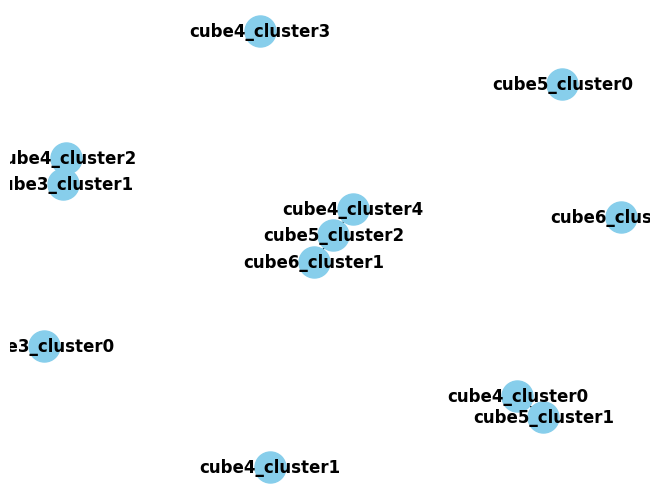

In [11]:
clusterer_all_ = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)

graph_all_ = mapper.map(projection_all,
                         filter_values_all,
                         clusterer=clusterer_all_,
                         cover=km.Cover(n_cubes=7, perc_overlap=0.25)
)

mapper.visualize(graph_all_, 
                 path_html="mapper_output_all_.html",
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all_)

In [12]:
def get_airports_from_graph(graph, nodes=None):
    airports = set()
    if nodes is not None:
        for node_id in graph['nodes'].keys():
            members = graph['nodes'][node_id]
            if len(members) >= nodes:
                nombres_miembros = [custom_tooltips_all[i] for i in members]
                airports.update(nombres_miembros)
    else:
        for node_id in graph['nodes'].keys():
            members = graph['nodes'][node_id]
            nombres_miembros = [custom_tooltips_all[i] for i in members]
            airports.update(nombres_miembros)
        
    return airports

airports_DBSCAN = get_airports_from_graph(graph_all, 7)

airports_HDBSCAN = get_airports_from_graph(graph_all_)

airports_in_both = airports_DBSCAN & airports_HDBSCAN

print(f"Porcentaje de aeropuertos de DBSCAN {len(airports_in_both) / len(airports_DBSCAN) * 100}")
print(f"Porcentaje de aeropuertos de HDBSCAN {len(airports_in_both) / len(airports_HDBSCAN) * 100}")


Porcentaje de aeropuertos de DBSCAN 100.0
Porcentaje de aeropuertos de HDBSCAN 75.67567567567568
